In [10]:
import seaborn as sns
import statsmodels.tsa.stattools as ts 
import statsmodels.api as sm
from numpy import log, polyfit, sqrt, std, subtract
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil.relativedelta import *

import pyfolio as pf

import ffn


from backtester import backtest as bt
from backtester import backtest_with_cost as btwc

%matplotlib inline

In [44]:
def create_pairs(tickers):
        result = []
        for p1 in range(len(tickers)):
                for p2 in range(p1+1,len(tickers)):
                        result.append([tickers[p1],tickers[p2]])
        return result
    
def get_closing(temp, name):
    temp.DATE = pd.to_datetime(temp['DATE'].str[:10], dayfirst=True)
    temp = temp.set_index(temp.DATE)
    
    temp.columns = ['Date', 'Symbol', 'Interval', 'Open', 'High', 'Low', name, 'Volume']
    temp = temp[name]
    return temp

    
def find_ssd(df, pairs):
    ssd = {}
    for p in pairs:
        pair = p[0]+','+p[1]
        A = df[p[0]]
        B = df[p[1]]
        s = np.sum((A-B)**2)
        
        if s == 0.0:
            s = 999.9    
        if len(A.dropna()) < 248 or len(B.dropna()) < 248:
            s = 999.9
        ssd[pair] = s
        
    return ssd


def find_tradeble_pairs(ssd, amount):
    sorted_lst = sorted(ssd, key=ssd.get)
    pair_lst = []
    for n in range(amount):
        pair_lst.append(sorted_lst[n].split(","))
    
    return pair_lst


def find_entry_exit(spread):
    mean = np.mean(spread)
    stdev = np.std(spread)
    upper = mean+2*stdev
    lower = mean-2*stdev
    
    return mean, upper, lower

def create_signal(df, pair, m, u, l):
    spread = df[pair[0]] - df[pair[1]]
    previous_spread = spread.shift(1)
    bt_df = pd.DataFrame()
    
    bt_df[pair[0]] = df[pair[0]]
    bt_df[pair[1]] = df[pair[1]]
    bt_df['shortsignal'] = ((spread < u) & (previous_spread > u))
    bt_df['longsignal'] = ((spread > l) & (previous_spread < l))
    bt_df['closelong'] = np.where(spread > m, 1, 0)
    bt_df['closeshort'] = np.where(spread < m, 1, 0)
    
    return bt_df


def trading(df_formation, df_trading, amount):
    returns = pd.DataFrame()
    
    ssd = find_ssd(df_formation, pairs)
    selected = find_tradeble_pairs(ssd, amount)
    
    for pair in selected:
        bt_name = pair[0]+pair[1]
        
        spread = df_formation[pair[0]] - df_formation[pair[1]]
        m, u, l = find_entry_exit(spread) 
        
        bt_df = create_signal(df_trading, pair, m, u, l)
        ret = bt(bt_df, pair[0], pair[1])
        
        returns[bt_name] = ret.returns
        print(pair)
        
    returns['mean'] = returns.mean(axis=1)
    returns = returns.set_index(df_trading.index)
    return returns['mean']
    
    

def backtest(df, amount):
    overall_ret = pd.DataFrame()
    
    start = pd.Timestamp('2000-01')
    mid = start + relativedelta(months=+12)
    end = start + relativedelta(months=+18)
    
    df_formation = (1 + df[start:mid].pct_change()).cumprod()
    df_trading = (1 + df[mid:end].pct_change()).cumprod()
    
    returns = trading(df_formation, df_trading, amount)
    overall_ret = returns
    
    print(start, mid, end)

    for period in range(1, 38):
        start = start + relativedelta(months=+6)
        mid = start + relativedelta(months=+12)
        end = start + relativedelta(months=+18)
        
        df_formation = (1 + df[start:mid].pct_change()).cumprod()
        df_trading = (1 + df[mid:end].pct_change()).cumprod()

        returns = trading(df_formation, df_trading, amount)
        overall_ret = overall_ret.append(returns)

        print(start, mid, end)
        
    return overall_ret

In [3]:
tickers = pd.read_excel('C:/Users/jango/Documents/BFH/BTHE/Sectors.xlsx', sheet_name=None)

hc_tickers = tickers['Health Care'].Ticker.tolist()
cg_tickers = tickers['Consumer Goods'].Ticker.tolist()
fin_tickers = tickers['Financials'].Ticker.tolist()
all_tickers = tickers['All'].Ticker.tolist()

In [39]:
UBS = pd.read_csv('C:/Users/jango/code/research_env/BTHE/Datalink/csv/UBSG.csv', delimiter=";")
UBS.DATE = pd.to_datetime(UBS['DATE'].str[:10], dayfirst=True)
df = pd.DataFrame(UBS.CLOSE).set_index(UBS.DATE)
df.columns = ['UBS']

In [40]:
for ticker in all_tickers:
    path = 'C:/Users/jango/code/research_env/BTHE/Datalink/csv/'+ticker+'.csv'
    df = df.join(get_closing(pd.read_csv(path, delimiter=";"), ticker)).ffill()
    #print(ticker + ' done')

In [41]:
df = df.drop(columns=['UBS'])
df.tail()

,ABBN,ADEN,ADVN,ADXN,AEVS,AFP,AIRE,ALC,ALLN,ALSN,...,VPBN,VZN,WARN,WIHN,WKBN,YPSN,ZEHN,ZUGN,ZURN,ZWM
DATE,,,,,,,,,,,,,,,,,,,,,
2020-03-12,15.740,36.50,145.0,1.380,12.60,18.26,1.00,46.425,196.4,144.8,...,121.4,281.0,2040.0,0.800,98.4,106.4,35.55,2170.0,286.9,250.0
2020-03-13,15.765,35.67,135.0,1.365,12.50,16.00,1.09,46.295,192.0,148.2,...,125.0,286.5,2040.0,0.952,99.6,111.0,35.20,2120.0,290.1,240.0
2020-03-16,15.160,33.81,135.0,1.220,11.50,13.30,0.95,45.885,182.8,136.2,...,117.0,280.5,1980.0,0.889,95.4,115.0,33.70,2090.0,269.7,240.0
2020-03-17,15.560,33.55,133.0,1.175,11.10,12.50,0.99,45.600,179.6,136.8,...,114.4,267.0,1920.0,0.810,94.8,112.0,34.90,1940.0,277.7,240.0
2020-03-18,15.045,33.21,120.0,1.025,10.85,12.12,0.93,44.460,175.6,131.2,...,113.0,256.0,1900.0,0.800,94.0,116.0,34.15,1880.0,266.9,240.0


In [42]:
pairs = create_pairs(all_tickers)

In [ ]:
amounts = [2, 5, 10]
master_lst = {}

for n in amounts:
    ret = backtest(df, n)
    master_lst[n] = ret

BPDG WKBN :  4 trades were made
['BPDG', 'WKBN']
GRKP WKBN :  1 trades were made
['GRKP', 'WKBN']
2000-01-01 00:00:00 2001-01-01 00:00:00 2001-07-01 00:00:00
BLKB LINN :  0 trades were made
['BLKB', 'LINN']
SPSN WKBN :  6 trades were made
['SPSN', 'WKBN']
2000-07-01 00:00:00 2001-07-01 00:00:00 2002-01-01 00:00:00
ARON GRKP :  1 trades were made
['ARON', 'GRKP']
BLKB BSKP :  2 trades were made
['BLKB', 'BSKP']
2001-01-01 00:00:00 2002-01-01 00:00:00 2002-07-01 00:00:00
BEKN BSKP :  0 trades were made
['BEKN', 'BSKP']
BLKB WKBN :  0 trades were made
['BLKB', 'WKBN']
2001-07-01 00:00:00 2002-07-01 00:00:00 2003-01-01 00:00:00
PSPN WKBN :  0 trades were made
['PSPN', 'WKBN']
BLKB HBLN :  2 trades were made
['BLKB', 'HBLN']
2002-01-01 00:00:00 2003-01-01 00:00:00 2003-07-01 00:00:00
UHR UHRN :  1 trades were made
['UHR', 'UHRN']
BCJ BPDG :  1 trades were made
['BCJ', 'BPDG']
2002-07-01 00:00:00 2003-07-01 00:00:00 2004-01-01 00:00:00
UHR UHRN :  2 trades were made
['UHR', 'UHRN']
LINN WKBN

In [27]:
ret = backtest(df)
#ret = pd.DataFrame(ret)

BPDG WKBN :  4 trades were made
['BPDG', 'WKBN']
GRKP WKBN :  1 trades were made
['GRKP', 'WKBN']
BLKB WKBN :  1 trades were made
['BLKB', 'WKBN']
BPDG GRKP :  2 trades were made
['BPDG', 'GRKP']
BLKB HBLN :  2 trades were made
['BLKB', 'HBLN']
BLKB LINN :  0 trades were made
['BLKB', 'LINN']
SPSN WKBN :  6 trades were made
['SPSN', 'WKBN']
BPDG WKBN :  1 trades were made
['BPDG', 'WKBN']
GRKP WKBN :  0 trades were made
['GRKP', 'WKBN']
ARON LINN :  0 trades were made
['ARON', 'LINN']
2000-07-01 00:00:00 2001-07-01 00:00:00 2002-01-01 00:00:00
ARON GRKP :  1 trades were made
['ARON', 'GRKP']
BLKB BSKP :  2 trades were made
['BLKB', 'BSKP']
BEKN WKBN :  1 trades were made
['BEKN', 'WKBN']
PSPN WKBN :  1 trades were made
['PSPN', 'WKBN']
ARON WKBN :  1 trades were made
['ARON', 'WKBN']
2001-01-01 00:00:00 2002-01-01 00:00:00 2002-07-01 00:00:00
BEKN BSKP :  0 trades were made
['BEKN', 'BSKP']
BLKB WKBN :  0 trades were made
['BLKB', 'WKBN']
BLKB BSKP :  1 trades were made
['BLKB', 'BSKP'

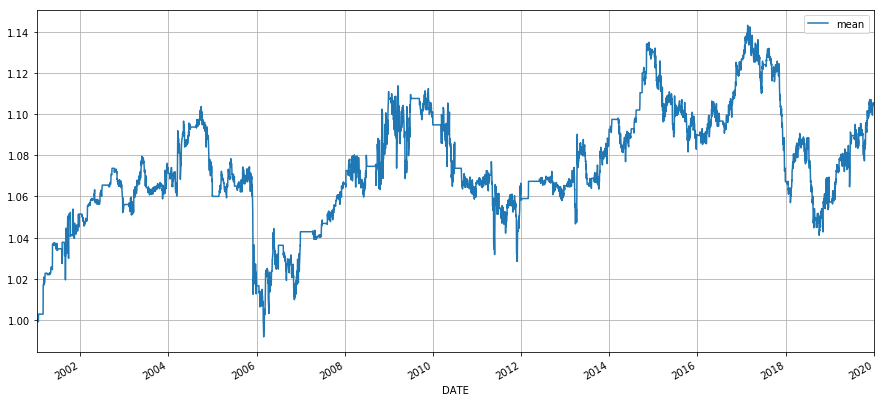

In [28]:
total_ret = pd.DataFrame(ret.cumsum() + 1)
total_ret.plot(figsize=(15,7),grid=True)

In [32]:
perf = total_ret.calc_stats() 
perf.display()

Stat                 mean
-------------------  ----------
Start                2001-01-03
End                  2019-12-30
Risk-free rate       0.00%

Total Return         10.43%
Daily Sharpe         0.14
Daily Sortino        0.22
CAGR                 0.52%
Max Drawdown         -10.15%
Calmar Ratio         0.05

MTD                  0.17%
3m                   1.33%
6m                   1.73%
YTD                  4.44%
1Y                   4.44%
3Y (ann.)            -0.67%
5Y (ann.)            -0.46%
10Y (ann.)           0.09%
Since Incep. (ann.)  0.52%

Daily Sharpe         0.14
Daily Sortino        0.22
Daily Mean (ann.)    0.62%
Daily Vol (ann.)     4.49%
Daily Skew           0.50
Daily Kurt           12.91
Best Day             3.35%
Worst Day            -2.27%

Monthly Sharpe       0.19
Monthly Sortino      0.30
Monthly Mean (ann.)  0.55%
Monthly Vol (ann.)   2.99%
Monthly Skew         -0.12
Monthly Kurt         2.70
Best Month           3.30%
Worst Month          -2.77%

Yearly Shar

In [140]:
len(df['2000']['BEKN'].dropna())

105

In [28]:
ssd = find_ssd(df_ind['2017-01':'2018-01'], pairs)
for n in ssd:
    if ssd[n] > 0.0:
        print(n, ssd[n])

NameError: name 'df_ind' is not defined

In [14]:
find_tradeble_pairs(ssd)[0][0]

'LISN'

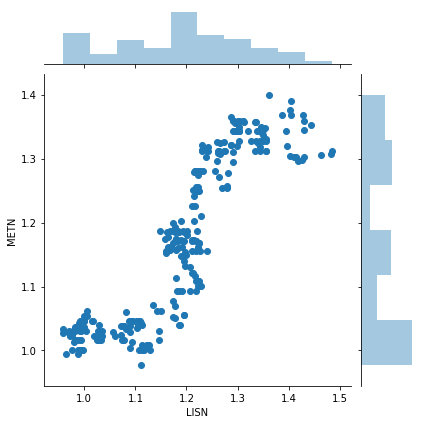

In [15]:
sns.jointplot(x="LISN", y="METN", data=df_ind['2005-01':'2006-01'])

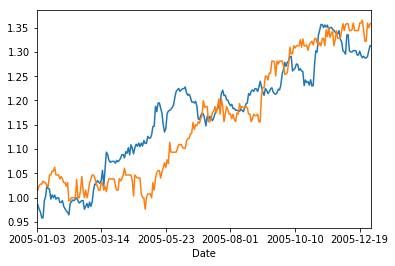

In [159]:
df_ind['LISN']['2005-01':'2006-01'].plot()
df_ind['METN']['2005-01':'2006-01'].plot()

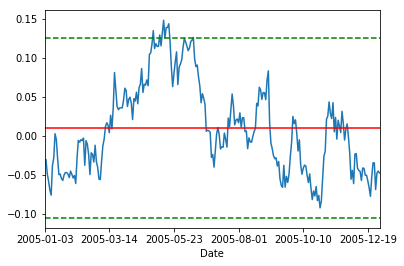

In [181]:
spread = df_ind['LISN']['2005-01':'2006-01'] - df_ind['METN']['2005-01':'2006-01']
mean = np.mean(spread)
stdev = np.std(spread)
upper = mean+2*stdev
lower = mean-2*stdev
spread.plot()
plt.axhline(mean, color='r', linestyle='-')
plt.axhline(upper, color='g', linestyle='--')
plt.axhline(lower, color='g', linestyle='--')

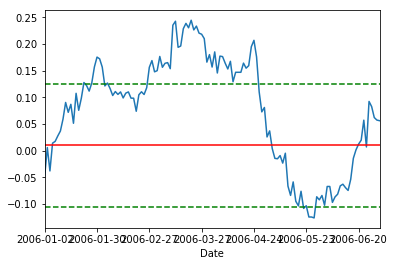

In [180]:
first_period = (1 + df['2006-01':'2006-07'].pct_change()).cumprod()
first_period_spread = df_ind['LISN']['2006-01':'2006-07'] - df_ind['METN']['2006-01':'2006-07']

first_period_spread.plot()

plt.axhline(mean, color='r', linestyle='-')
plt.axhline(mean+2*stdev, color='g', linestyle='--')
plt.axhline(mean-2*stdev, color='g', linestyle='--')

In [187]:
bt_df = pd.DataFrame()

In [193]:
bt_df['LISN'] = df['LISN']['2006-01':'2006-07']
bt_df['METN'] = df['METN']['2006-01':'2006-07']

bt_df['shortsignal'] = np.where(first_period_spread > upper, 1, 0)
bt_df['longsignal'] = np.where(first_period_spread < lower, 1, 0)
bt_df['closelong'] = np.where(first_period_spread > mean, 1, 0)
bt_df['closeshort'] = np.where(first_period_spread < mean, 1, 0)

In [391]:
backtest = bt(bt_df, 'LISN', 'METN')

going short: X 20104.806641 Y 1019.801025
closing short: X 22167.787109 Y 1232.105103
going long: X 19530.580078 Y 1173.200195
closing long: X 20876.787109 Y 1153.565186
2 trades were made


In [392]:
ret = pd.DataFrame(backtest.cum_returns)
ret.index = pd.to_datetime(ret.index)

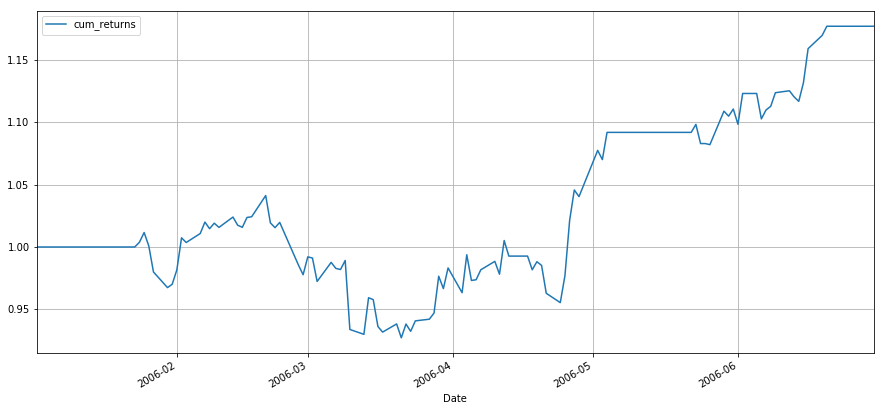

In [393]:
ret.iloc[0] = 1
ret.plot(figsize=(15,7),grid=True)

In [228]:
perf = ret.calc_stats() 
perf.display()

Stat                 cum_returns
-------------------  -------------
Start                2006-01-02
End                  2006-06-30
Risk-free rate       0.00%

Total Return         17.69%
Daily Sharpe         1.63
Daily Sortino        2.83
CAGR                 39.41%
Max Drawdown         -10.95%
Calmar Ratio         3.60

MTD                  5.97%
3m                   21.74%
6m                   -
YTD                  17.69%
1Y                   -
3Y (ann.)            -
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  39.41%

Daily Sharpe         1.63
Daily Sortino        2.83
Daily Mean (ann.)    34.26%
Daily Vol (ann.)     20.98%
Daily Skew           0.01
Daily Kurt           3.28
Best Day             4.52%
Worst Day            -5.59%

Monthly Sharpe       4.53
Monthly Sortino      inf
Monthly Mean (ann.)  47.70%
Monthly Vol (ann.)   10.52%
Monthly Skew         -0.55
Monthly Kurt         -3.21
Best Month           6.75%
Worst Month          0.55%

Yearly Sharpe    

C:\Users\jango\Anaconda3\envs\research\lib\site-packages\ffn\core.py:2056: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


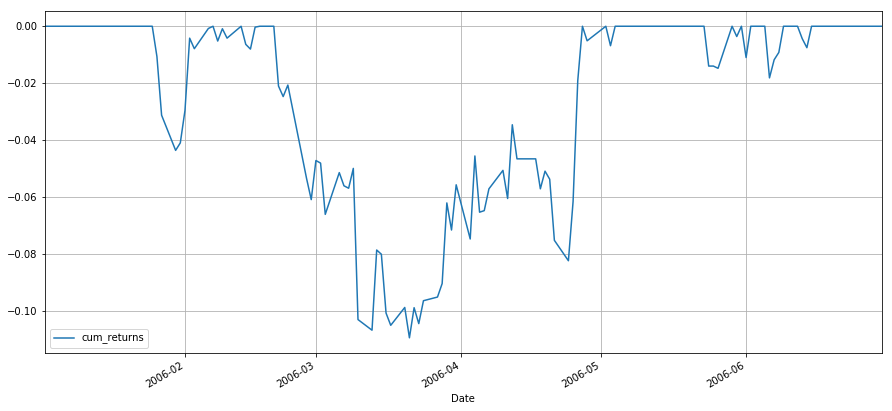

In [229]:
ffn.to_drawdown_series(ret).plot(figsize=(15,7),grid=True) 

In [324]:
start = pd.Timestamp('2005-01')

In [325]:
start + pd.DateOffset(month=6)

Timestamp('2005-06-01 00:00:00')

In [249]:
current_month = df.index[0]

for index, row in df['2015':'2017'].iterrows():
    if index < current_month and current_month.isoweekday() in range(1, 6):
        pass
    else:
        current_month = (index + pd.offsets.MonthEnd() - pd.DateOffset(1))
        if current_month.isoweekday() in range(6, 7):
            current_month = (current_month - pd.DateOffset(1))

    if index == current_month:
        print(current_month)

2015-01-30 00:00:00
2015-02-27 00:00:00
2015-03-30 00:00:00
2015-04-29 00:00:00
2015-05-29 00:00:00
2015-06-29 00:00:00
2015-07-30 00:00:00
2015-09-29 00:00:00
2015-10-30 00:00:00
2015-12-30 00:00:00
2016-01-29 00:00:00
2016-03-30 00:00:00
2016-04-29 00:00:00
2016-05-30 00:00:00
2016-06-29 00:00:00
2016-07-29 00:00:00
2016-08-30 00:00:00
2016-09-29 00:00:00
2016-11-29 00:00:00
2016-12-30 00:00:00
2017-01-30 00:00:00
2017-02-27 00:00:00
2017-03-30 00:00:00
2017-04-28 00:00:00
2017-05-30 00:00:00
2017-06-29 00:00:00
2017-08-30 00:00:00
2017-09-29 00:00:00
2017-10-30 00:00:00
2017-11-29 00:00:00
2017-12-29 00:00:00


Start date,2001-01-03
End date,2020-03-18
Total months,231
,Backtest
Annual return,0.7%
Cumulative returns,13.9%
Annual volatility,5.3%
Sharpe ratio,0.15
Calmar ratio,0.06
Stability,0.46
Max drawdown,-10.6%


C:\Users\jango\Anaconda3\envs\research\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,10.56,2008-12-29,2010-12-09,2019-06-21,2735
1,8.69,2001-11-02,2003-02-14,2007-09-28,1541
2,3.33,2008-11-05,2008-11-12,2008-12-29,39
3,2.92,2008-03-03,2008-06-05,2008-09-26,150
4,2.80,2020-03-13,2020-03-18,NaT,NaN


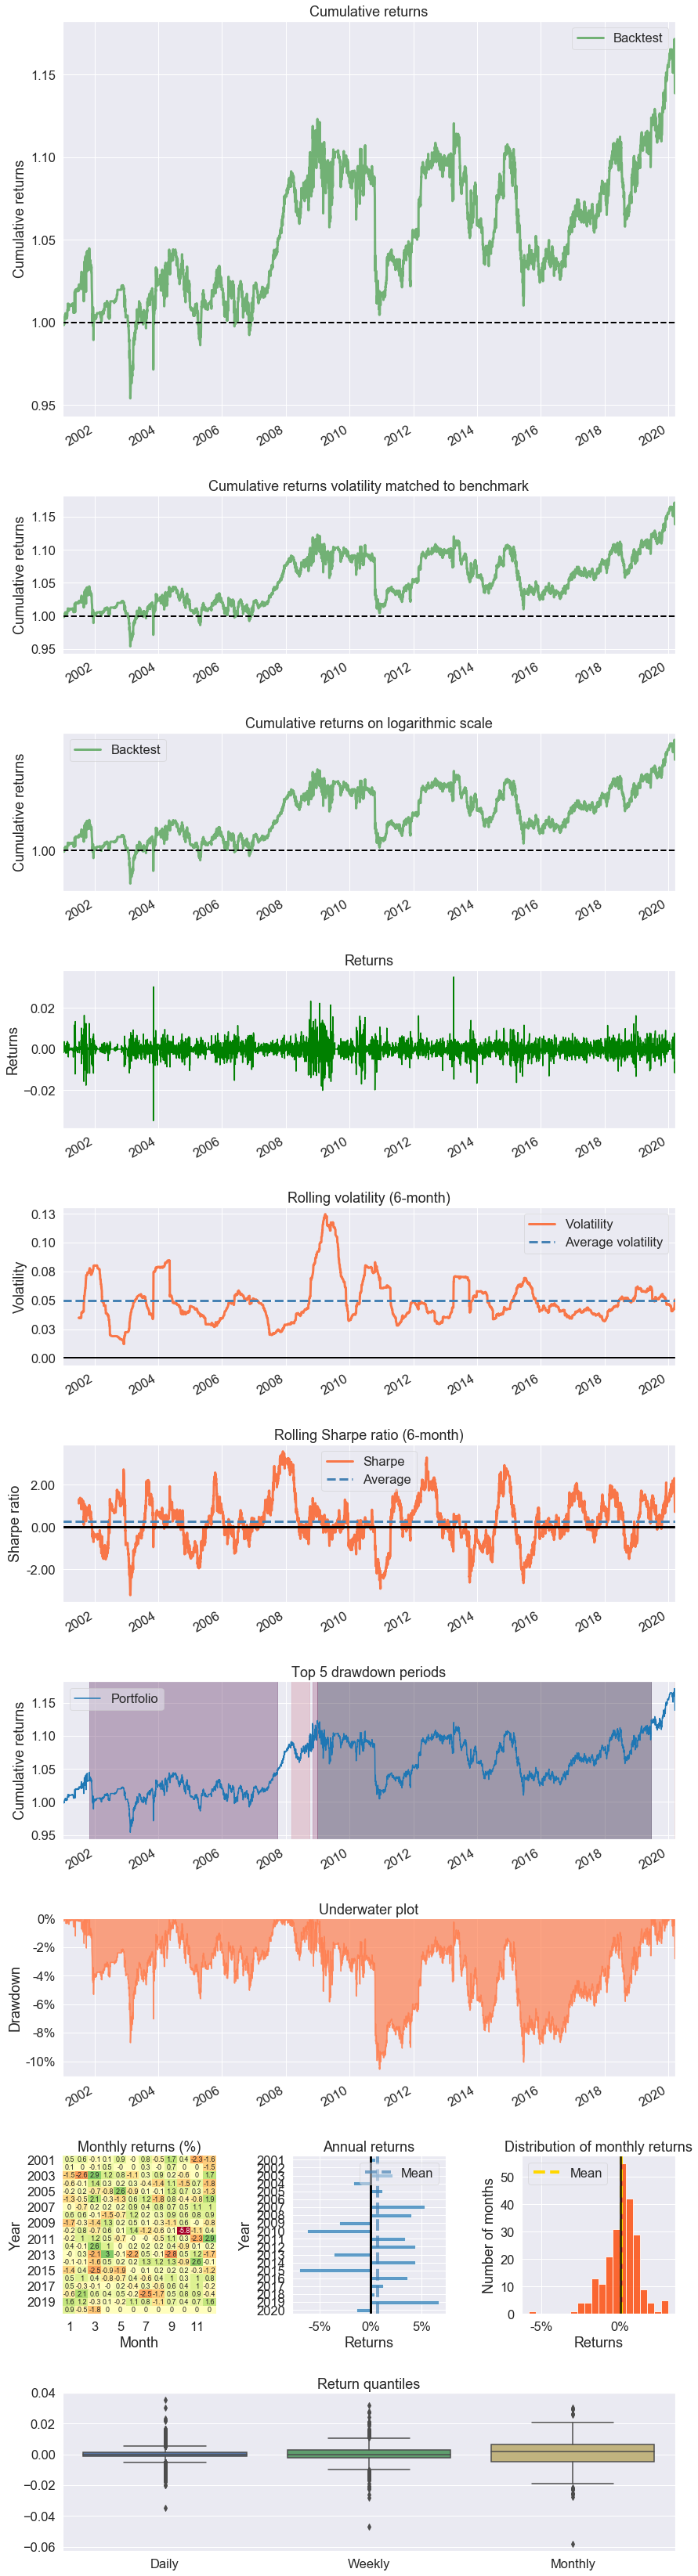

ValueError: cannot reindex from a duplicate axis

In [11]:
pf.create_full_tear_sheet(ret, benchmark_rets=None)